# import modules

In [9]:
import sys
import os
home = os.path.expanduser("~")
sys.path.append(f'{home}/TorchFiber')
from src.NewSimulation.config import *

tx_data = simpleWDMTx(False, jax.random.PRNGKey(0), batch=1, M=16, Nbits=100, sps=16, Nch=1, Nmodes=1, Rs=36e9, freqspace=50e9, Pch_dBm=0)
Pch = 10**(tx_data['config']['Pch_dBm']/10)*1e-3
tx_data['signal'] = tx_data['signal'] / jnp.sqrt(Pch)         # power normalization
print('(batch, Nfft, Nmodes), (batch, Nsymb, Nch, Nmodes)')
print(tx_data['signal'].shape, tx_data['SymbTx'].shape)


print(f'\nEach fiber span length Ls = {Ls} km.')
print(f'Dispersion length Ld = {Ld} km.')
print(f'Nonlinear length Lnl = {Lnl} km.')
print(f'nonlinear coeff gamma = {gamma} /W/km .')

Sample rate fa: 5.76e+11, Cut off frequency fc: 2.5e+10, fa > 2fc: True
 simpleWDMTx complete, time cost(s):0.11572885513305664
(batch, Nfft, Nmodes), (batch, Nsymb, Nch, Nmodes)
(1, 400, 1) (1, 25, 1, 1)

Each fiber span length Ls = 80 km.
Dispersion length Ld = 40 km.
Nonlinear length Lnl = 400 km.
nonlinear coeff gamma = 0.1 /W/km .


# Solve NLSE

In [14]:
# initial condition
u0 = tx_data['signal'][0,:,0]

# parameters
spans = 8                # Number of spans
z_max = spans*Ls/Ld
dt = 1/tx_data['config']['sps']
print(f'z_max = {z_max} Ld')

# solve with full sps = 16
uc = Dispersion(u0, dt, z_max)                                          # dispersion solution
us = SSFM(u0, dt, dz=1, L=z_max, gamma=gamma, order=1, path=False)      # large step solution
ur = SSFM(u0, dt, dz=1/2**8, L=z_max, gamma=gamma, order=2, path=False) # real solution

z_max = 16.0 Ld


In [15]:
# solve with downsampled sps = 2 and reconstruct to sps=16.
rate = 8     # downsample rate
u0_downsamp = u0[::rate]    # sps=16 --> sps=2
uc_downsamp = SSFM(u0_downsamp, dt*rate, dz=z_max,  L=z_max, gamma=0, order=1, path=False)       # dispersion solution
us_downsamp = SSFM(u0_downsamp, dt*rate, dz=2,    L=z_max, gamma=gamma, order=1,path=False)     # NLSE solution
ur_downsamp = SSFM(u0_downsamp, dt*rate, dz=1/2**6, L=z_max, gamma=gamma, order=2,path=False)  # real solution

uc1 = reconstruct(uc_downsamp, rate)   # sps=2 --> sps=16  dispersion solution
us1 = reconstruct(us_downsamp, rate)   # sps=2 --> sps=16  large step solution
ur1 = reconstruct(ur_downsamp, rate)   # sps=2 --> sps=16  real solution (small step)

def MSE(u, ur):
    return np.mean(np.abs(ur - u)**2)

print('dispersion only:', MSE(uc, ur))
print('SSFM large dz:', MSE(us1, ur))
print('SSFM small dz:', MSE(ur1, ur))

# MSE(us_downsamp, ur[0::rate])

dispersion only: 0.5665634160904173
SSFM large dz: 0.012344293
SSFM small dz: 8.8183435e-05


# Calc X

## 1. Approximate X

In [16]:
def approximate_X(z, m,n, Ts=0.5):
    eta = z / Ts**2
    m = m[None, :, None]
    n = n[None, None, :]
    z = z[:, None, None]
    eta = eta[:, None, None]
    return Ts/(2*np.pi) * np.exp(1j*m*n/eta)/eta * np.maximum(1 - (np.abs(m) + np.abs(n))/(2*np.pi*eta),0)

z1 = np.linspace(0.01, 2, 161)

N = 80
X1 = approximate_X(z1, np.roll((np.arange(-N,N+1)), N+1), np.roll((np.arange(-N,N+1)), N+1))
Xbar = np.cumsum(f(z1)[:,None,None]*X1, axis=0)*(z1[2] - z1[1])
def valid(X, threshold=1e-3):
    return np.sum(np.abs(X) > threshold)

## 2. Numerical Integration

In [19]:
import pickle
X,z = pickle.load(open('../data/Xcoeff_161_dz0.01_zmax16_Ts0.5_2D.pkl', 'rb'))
Xint = np.sum(X*f(z)[:, None, None]*z[1], axis=0)
Ts = 0.5

# X2,z2 = pickle.load(open('../data/Xcoeff_161_dz1_zmax16_Ts0.5_2D.pkl', 'rb'))
# Xint2 = np.sum(X2*f(z2)[:, None, None]*z2[1], axis=0)

# X3,z3 = pickle.load(open('../data/Xcoeff_161_dz2_zmax16_Ts0.5_2D.pkl', 'rb'))
# Xint3 = np.sum(X3*f(z3)[:, None, None]*z3[1], axis=0)


In [11]:
# m,n = 0,0

# print(Xint[m,n].real, Xint2[m,n].real, Xint3[m,n].real)

# plt.plot(z, X[:,m,n].real * f(z))
# plt.plot(z2, X2[:,m,n].real * f(z2))
# plt.plot(z3, X3[:,m,n].real * f(z3))

## 3. compare

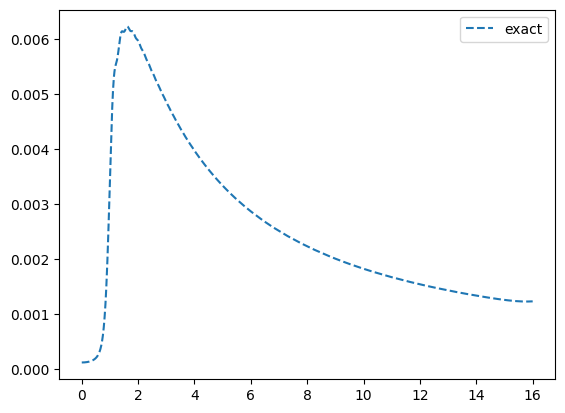

In [20]:
m,n = 0,20
# plt.plot(z1, X1[:,m, n].real, '-', label='approx')
plt.plot(z, X[:,m,n].real, '--', label='exact')
plt.legend()

In [513]:
# Xshow = np.maximum(np.abs(Xbar), 1e-3)
# plt.imshow(np.fft.fftshift(np.log10(np.abs(Xshow[-1]))), aspect='auto')
# print(valid(Xbar[-1]))
# plt.colorbar()

# PNSE

In [51]:
import pickle

def NonlinearCouple(a, X, S, Ts=0.5):
    a_delta = np.zeros_like(a)
    for (m,n,k) in S:
        a_delta += X[m, n, k]*np.roll(a, m)*np.roll(a, n)*np.roll(a, k).conj()
    return -(1j)/Ts*gamma*a_delta



def Nf(a, X, S, Ts=0.5):
    a_delta = np.zeros_like(a)
    for (m,n) in S:
        if np.abs(X[m,n]) > 1e-4:
            a_delta += X[m, n]*np.roll(a, m)*np.roll(a, n)*np.roll(a, m+n).conj()
    return -(1j)/Ts*gamma*a_delta

def AM(a, X, S, Ts=0.5):
    a_delta = np.zeros_like(a)
    m_delta = np.zeros_like(a)
    for (m,n) in S:
        if np.abs(X[m,n]) > 1e-4 and m*n ==0:
            m_delta += X[m, n]*np.roll(a, m)*np.roll(a, n)*np.roll(a, m+n).conj()
        elif np.abs(X[m,n]) > 1e-4 and m*n !=0:
            a_delta += X[m, n]*np.roll(a, m)*np.roll(a, n)*np.roll(a, m+n).conj()
        else:
            pass
    return -(1j)/Ts*gamma*a_delta, -(1j)/Ts*gamma*m_delta


def MSE(u, ur):
    return np.mean(np.abs(ur - u)**2)


S0 = [(m,n) for m in range(-80,81) for n in range(-80,81)]

In [58]:
import pickle
X,z = pickle.load(open('../data/Xcoeff_161_dz0.5_zmax16_Ts0.5_2D.pkl', 'rb'))
Xint = np.sum(X*f(z)[:, None, None]*z[1], axis=0)
Ts = 0.5

In [60]:
def solver1(u0, X, z, S, dt, rate, k, factor=1, Ts=0.5):
    u1 = u0
    for j in range(len(k) - 1):
        Xj = np.sum(X[k[j]: k[j+1]]*f(z[k[j]: k[j+1]])[:, None, None], axis=0)*z[1]*factor
        phi = Nf(u1, Xj, S, Ts)
        if j > 0:
             u1 = u1*np.exp(phi/u1)
        else:
            u1 = u1 + phi
    u1 = Dispersion(u1, dt*rate, z[-1])
    u1_rec = reconstruct(u1, rate)
    return u1_rec

def solver2(u0, X, z, S, dt, rate, k, factor=1, Ts=0.5):
    u1 = u0
    for j in range(len(k) - 1):
        Xj = np.sum(X[k[j]: k[j+1]]*f(z[k[j]: k[j+1]])[:, None, None], axis=0)*z[1]*factor
        add, mul = AM(u1, Xj, S, Ts)
        u1 = u1*np.exp(mul/u1) + add
       
    u1 = Dispersion(u1, dt*rate, z[-1])
    u1_rec = reconstruct(u1, rate)
    return u1_rec


Text(0.5, 1.0, 'factor = 1')

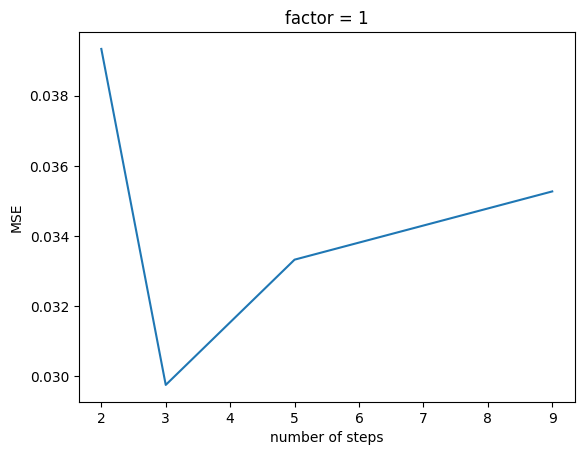

In [61]:
Es = []

ss = [2,3,5,9]

for steps in ss:
    u1_rec = solver2(u0_downsamp, X, z, S0, dt, rate, np.linspace(0,len(z) - 1, steps, dtype=int))
    Es.append(MSE(u1_rec, ur))


plt.plot(ss, Es)
plt.xlabel('number of steps')
plt.ylabel('MSE')
plt.title('factor = 1')

In [62]:
Es

[0.03933517, 0.029747667, 0.03332211, 0.03526908]

In [37]:
# Add scheme
Es

[0.09047808, 0.03762691, 0.024397286, 0.022491015]

0.00029458097


Text(0, 0.5, 'MSE')

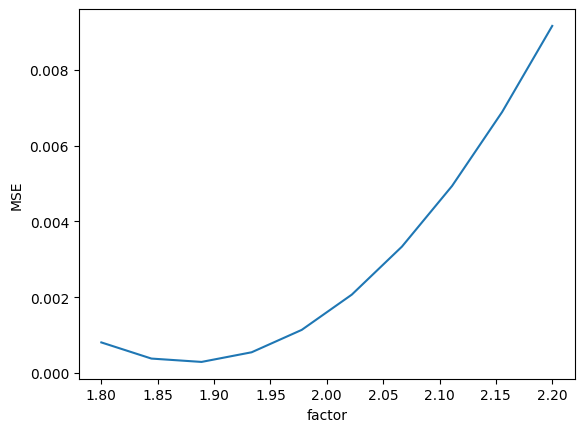

In [33]:
Es = []
for factor in np.linspace(1.8, 3, 10):
    u1_rec = solver(u0_downsamp, X, z, S0, dt, rate, np.linspace(0,len(z) - 1, 2, dtype=int), factor=factor)
    Es.append(MSE(u1_rec, ur))

print(np.min(Es))
plt.plot(np.linspace(1.8, 2.2, 10), Es)
plt.xlabel('factor')
plt.ylabel('MSE')

## Euler

In [354]:
er_list1 = []

for step_size in [16, 8, 4, 2, 1]:   # unit [dz]
    u1 = u0_downsamp
    for i in range(0, len(z)-1, step_size):
        phi = NonlinearCouple(u1, sum([X[j]*f(z[j]*z[1]) for j in range(i, i+step_size)]), S6)            
        u1 = u1 + phi

    u1 = Dispersion(u1, dt*rate, z_max)
    u1_rec = reconstruct(u1, rate)

    er_list1.append(MSE(u1_rec, ur))
    print('\n')
    print('step size:', step_size)
    print('dispersion only:', MSE(uc, ur))
    print('RP1:', MSE(u1_rec, ur))
    print('SSFM:', MSE(us1, ur))



step size: 16
dispersion only: 0.6813180398706223
RP1: 0.14650618
SSFM: 0.013790636


step size: 8
dispersion only: 0.6813180398706223
RP1: 0.06030911
SSFM: 0.013790636


step size: 4
dispersion only: 0.6813180398706223
RP1: 0.02717951
SSFM: 0.013790636


step size: 2
dispersion only: 0.6813180398706223
RP1: 0.018308245
SSFM: 0.013790636


step size: 1
dispersion only: 0.6813180398706223
RP1: 0.017347217
SSFM: 0.013790636


In [27]:
er_list2 = []

for step_size in [16, 8, 4, 2, 1]:
    u1 = u0_downsamp
    for i in range(0, len(z)-1, step_size):
        phi = NonlinearCouple(u1, sum([X[j]*f(z[j]) for j in range(i, i+step_size)]), S4)*z[1]            
        u1 = u1 * np.exp(phi.imag*(1j) / u1) + phi.real

    u1 = Dispersion(u1, dt*rate, z_max)
    u1_rec = reconstruct(u1, rate)

    er_list2.append(MSE(u1_rec, ur))
    print('step size:', step_size)
    print('dispersion only:', MSE(uc, ur))
    print('RP1:', MSE(u1_rec, ur))
    print('SSFM:', MSE(us1, ur))

step size: 16
dispersion only: 0.6813180398706223
RP1: 0.31028178
SSFM: 0.06737972
step size: 8
dispersion only: 0.6813180398706223
RP1: 0.29117593
SSFM: 0.06737972
step size: 4
dispersion only: 0.6813180398706223
RP1: 0.28532502
SSFM: 0.06737972
step size: 2
dispersion only: 0.6813180398706223
RP1: 0.2840849
SSFM: 0.06737972
step size: 1
dispersion only: 0.6813180398706223
RP1: 0.28397882
SSFM: 0.06737972


In [28]:
er_list3 = []

for step_size in [16, 8, 4, 2, 1]:
    u1 = u0_downsamp
    for i in range(0, len(z)-1, step_size):
        phi = NonlinearCouple(u1, sum([X[j]*f(z[j]) for j in range(i, i+step_size)]), S4)*z[1]            
        u1 = u1 * np.exp(phi / u1)

    u1 = Dispersion(u1, dt*rate, z_max)
    u1_rec = reconstruct(u1, rate)

    er_list3.append(MSE(u1_rec, ur))
    print('step size:', step_size)
    print('dispersion only:', MSE(uc, ur))
    print('RP1:', MSE(u1_rec, ur))
    print('SSFM:', MSE(us1, ur))

step size: 16
dispersion only: 0.6813180398706223
RP1: 0.28437012
SSFM: 0.06737972
step size: 8
dispersion only: 0.6813180398706223
RP1: 0.28427002
SSFM: 0.06737972
step size: 4
dispersion only: 0.6813180398706223
RP1: 0.28420952
SSFM: 0.06737972
step size: 2
dispersion only: 0.6813180398706223
RP1: 0.2841629
SSFM: 0.06737972
step size: 1
dispersion only: 0.6813180398706223
RP1: 0.2841565
SSFM: 0.06737972


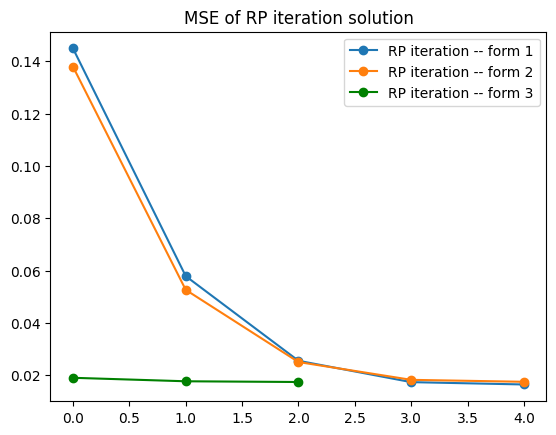

In [16]:
plt.plot(er_list1, marker='o', linestyle='-', label='RP iteration -- form 1')
plt.plot(er_list2, marker='o', linestyle='-', label='RP iteration -- form 2')
plt.plot(er_list3, marker='o', linestyle='-', label='RP iteration -- form 3', color='g')
plt.title('MSE of RP iteration solution')
plt.legend()

In [33]:
u1 = u0_downsamp
step_size = 8
for i in range(0, len(z)-1, step_size):
    phi = NonlinearCouple(u1, sum([X[j]*f(z[j]) for j in range(i, i+step_size)]), S4)*z[1]            
    u1 = u1*np.exp(phi / u1)

u1 = Dispersion(u1, dt*rate, z_max)
u1_rec = reconstruct(u1, rate)

print('dispersion only:', MSE(uc, ur))
print('RP1:', MSE(u1_rec, ur))
print('SSFM:', MSE(us1, ur))

dispersion only: 0.6813180398706223
RP1: 0.10113662
SSFM: 0.06737972
